In [1]:
import pandas as pd
import matplotlib as plt
import statsmodels.api as sm

# Прогнозирование временных рядов
## Компоненты временных рядов
Какие компоненты обычно выделяют во временных рядах?

__Ответ:__ сезонность, ошибка, тренд, цикл.

## Особенности временных рядов

Какие особенности характерны для временных рядов?

__Ответ:__ Временные ряды, как правило, автокоррелированы, то есть, их значения в каждый момент времени в каком-то смысле похожи на значения в недавнем прошлом.

## Слагаемые ARMA
Из каких слагаемых состоит модель ARMA(p,q)?

__Ответ:__ 
- Константа $\alpha$ (TRUE)
- Ошибка $\varepsilon_t$
- $p$ предыдущих значений ряда с постоянными коэффициентами 

## МНК и SARIMA

Какие из параметров модели SARIMA настраиваются с помощью метода наименьших квадратов?

- Значения коэффициентов $\phi$ и $\theta$ перед предыдущими значениями ряда и предыдущими значениями ошибки
- Значение константы $\alpha$ 

## Начальное приближение гиперпараметров ARIMA
Какой эвристический метод позволяет выбрать начальное приближение для гиперпараметров $p$ и $P$ в сезонной модели ARIMA?

__Ответ:__ Анализ частичной автокорреляционной функции


## График
В приложенном файле — данные по ежемесячному уровню производства молока в фунтах на одну корову.

Загрузите ряд, создайте новый ряд значений среднего дневного уровня производства молока в фунтах на одну корову, поделив на число дней в месяце (вычисляется с помощью функции monthrange из пакета calendar). Постройте график полученного ряда; какой из приведённых ниже графиков у вас получился?

In [2]:
milk = pd.read_csv('monthly-milk-production.csv',
                   sep = ';', index_col=['month'], 
                   parse_dates=['month'], dayfirst=True)
milk.head()

,milk
month,
1962-01-01,589
1962-02-01,561
1962-03-01,640
1962-04-01,656
1962-05-01,727


In [3]:
milk['daily'] = milk.milk / milk.index.days_in_month
milk.head()

,milk,daily
month,,
1962-01-01,589,19.000000
1962-02-01,561,20.035714
1962-03-01,640,20.645161
1962-04-01,656,21.866667
1962-05-01,727,23.451613


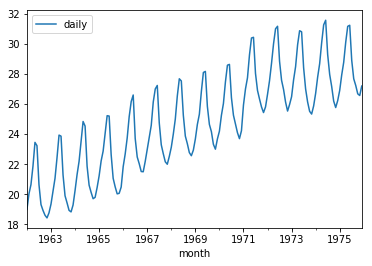

In [4]:
milk.plot(y = 'daily')

## Стационарность
Для ряда со средним дневным количеством молока на корову из предыдущего вопроса давайте с помощью критерия Дики-Фуллера подберём порядок дифференцирования, при котором ряд становится стационарным.

Дифференцирование можно делать так:
```
milk.daily_diff1 = milk.daily - milk.daily.shift(1)
```
Чтобы сделать сезонное дифференцирование, нужно изменить значение параметра у функции shift:
```
milk.daily_diff12 = milk.daily - milk.daily.shift(12)
```
При дифференцировании длина ряда сокращается, поэтому в части строк в новой колонке значения будут не определены (NaN). Подавая полученные столбцы на вход критерию Дики-Фуллера, отрезайте неопределённые значения, иначе вы получите неопределённый достигаемый уровень значимости. 

In [5]:
def isStationarity(series):
    p_val = sm.tsa.stattools.adfuller(series)[1]
    print(p_val)
    return p_val < 0.05

def addShift(series, shift):
    shift_series = series - series.shift(shift)
    shift_series = shift_series.dropna()
    return shift_series

In [6]:
daily_diff1 = addShift(milk.daily, 1)
print('Смещение на 1 месяц даёт стационарность? Ответ: ',isStationarity(daily_diff1))

0.06430054654174842
Смещение на 1 месяц даёт стационарность? Ответ:  False


In [7]:
daily_diff12 = addShift(milk.daily, 12)
print('Смещение на 12 месяцев даёт стационарность? Ответ: ',isStationarity(daily_diff12))

0.22127672658830344
Смещение на 12 месяцев даёт стационарность? Ответ:  False


In [8]:
daily_diff12 = addShift(milk.daily, 12)
daily_diff12_1 = addShift(daily_diff12, 1)
print('Смещение на 12 месяцев и потом на 1 даёт стационарность? Ответ: ',isStationarity(daily_diff12_1))

2.2808455518036712e-06
Смещение на 12 месяцев и потом на 1 даёт стационарность? Ответ:  True


In [9]:
daily_diff1 = addShift(milk.daily, 1)
daily_diff1_12 = addShift(daily_diff1, 12)
print('Смещение на 1 месяц и потом на 12 месяцев даёт стационарность? Ответ: ',isStationarity(daily_diff1_12))

2.2808455518036712e-06
Смещение на 1 месяц и потом на 12 месяцев даёт стационарность? Ответ:  True


## Начальное приближение
Для стационарного ряда из предыдущего вопроса (продифференцированного столько раз, сколько вы посчитали нужным) постройте график автокорреляционной функции. Это можно cделать так:
```
import statsmodels.api as sm
sm.graphics.tsa.plot_acf(ряд.values.squeeze(), lags=50)
```
Исходя из этого графика, какое начальное приближение вы предложили бы для параметра $Q$ в модели SARIMA?

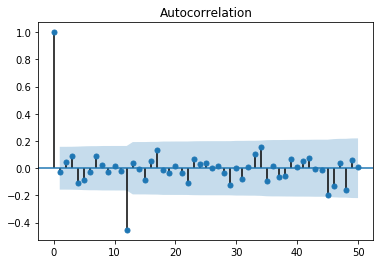

In [10]:
sm.graphics.tsa.plot_acf(daily_diff12_1.values.squeeze(), lags=50);

__Ответ:__ 1, ибо в первом сезоне виден значимое значение.

Для того же ряда, что и в предыдущем вопросе, постройте график частичной автокорреляционной функции. Это можно сделать так:
```
import statsmodels.api as sm
sm.graphics.tsa.plot_pacf(ряд.values.squeeze(), lags=50)
```
Исходя из этого графика, какое начальное приближение вы предложили бы для параметра $p$ в модели SARIMA?

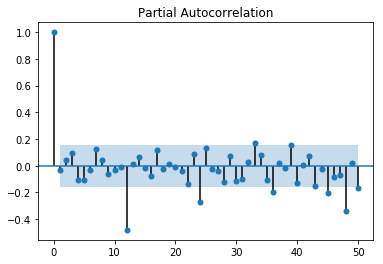

In [11]:
sm.graphics.tsa.plot_pacf(daily_diff12_1.values.squeeze(), lags=50);

__Ответ:__ 0, так как нет смысла выбирать параметр $p$ больше сезонности, равной 12.